In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



# 1. Data Understanding / Preparation

## 1.1 Data Retrieval

In [2]:
# Reading Accounts' Data
acc = pd.read_csv("./processed/account.csv", sep=";")

# Reading Transactions' Data
trans = pd.read_csv("./processed/trans_dev.csv", sep=";");
#trans = pd.read_csv("./processed/trans_comp.csv", sep=";");

# Reading Loans' Data
loan = pd.read_csv("./processed/loan_dev.csv", sep=";");
#loan = pd.read_csv("./processed/loan_comp.csv", sep=";");

# Reading Districts' Data
dist = pd.read_csv("./raw/district.csv", sep=";");

# Reading Disponents' Data
disp = pd.read_csv("./processed/disp.csv", sep=";");

# Reading Cards' Data
card = pd.read_csv("./processed/card_dev.csv", sep=";");
#card = pd.read_csv("./processed/card_comp.csv", sep=";");

# Reading Clients' Data
clie = pd.read_csv("./processed/client.csv", sep=";");

In [3]:
# Confirming all files were read successfully.
# General overview of number of attributes (columns) and entries (rows) per table, missing values, types of variables.
#for df in [acc, trans, loan, dist, disp, card, clie]:
#    print(df.info())
#    print("\n")

## 1.2 Data Integration - Grouping all columns of all files into a single dataframe

In [4]:
# Merging Accounts' and Transactions' Data

complete = pd.merge(acc, pd.DataFrame(trans.groupby('account_id').size(), columns=['# trans']), right_index=True, left_on='account_id', how="outer")

# Oper 1 - credit in cash, Oper 2 - credit card withdrawal, Oper 3 - collection from another bank, Oper 4 - remittance to another bank, Oper 5 - withdrawal in cash
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='credit in cash'].groupby('account_id').size(), columns=['oper #1']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='credit card withdrawal'].groupby('account_id').size(), columns=['oper #2']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='collection from another bank'].groupby('account_id').size(), columns=['oper #3']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='remittance to another bank'].groupby('account_id').size(), columns=['oper #4']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='withdrawal in cash'].groupby('account_id').size(), columns=['oper #5']), right_index=True, left_on='account_id', how="outer")

# Type 1 - withdrawal, Type 2 - withdrawal in cash, Type 3 - credit 
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='withdrawal'].groupby('account_id').size(), columns=['type #1']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='withdrawal in cash'].groupby('account_id').size(), columns=['type #2']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='credit'].groupby('account_id').size(), columns=['type #3']), right_index=True, left_on='account_id', how="outer")

complete = pd.merge(complete, pd.DataFrame(trans.groupby('account_id').amount.mean().round(2)).rename(columns={'amount':'avg trans amount'}), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans.groupby('account_id').balance.mean().round(2)).rename(columns={'balance':'avg trans balance'}), right_index=True, left_on='account_id', how="outer")
# (4500, 15)

# ------------------------

# Merging with Loans' Data
complete = pd.merge(complete, loan.rename(columns={'date': 'loan date', 'amount': 'loan amount', 'duration': 'loan duration (mths)', 'payments': 'loan payments', 'status': 'loan status'}))
# (328, 21)

# ------------------------

# Merging with Districts' Data
complete = pd.merge(complete, dist.rename(columns={'code ': 'district_id', 'name ': 'district_name', 'region': 'district_region'}))
# (328, 36)

# ------------------------

# Merging Disp' and Cards' Data
disp = disp.rename(columns={"type": "disp type"})
disp['has disponent'] = np.where(disp['disp type'] == 'DISPONENT', True, False)
card = card.rename(columns={"type": "card type"})
disp_card = pd.merge(disp, card, how="outer")
# (5369, 9)

# ------------------------

# Merging Previous with Clients' Data
disp_card_clie = pd.merge(disp_card, clie).drop_duplicates(subset=['account_id']).drop(columns=['has disponent', 'disp type', 'district_id', 'disp_id'])
# (4500, 7)
temp = pd.merge(disp_card_clie, pd.DataFrame(disp_card.groupby('account_id').size(), columns = ['count owner']), right_index=True, left_on='account_id', how="outer")
disp_card_clie['has disponent'] = np.where(temp['count owner'] == 2, True, False)
# (4500, 8)

# ------------------------

# Merging Previous subset with the rest
complete = pd.merge(complete, disp_card_clie)


print(complete.shape)
complete


(328, 43)


,account_id,district_id,frequency,date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan_id,loan date,loan amount,loan duration (mths),loan payments,loan status,district_name,district_region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,client_id,card_id,card type,issued,birthdate,sex,has disponent
0,5270,44,monthly issuance,1993-01-13,53.0,1.0,NaN,11.0,NaN,31.0,28.0,3.0,22.0,17600.36,69954.57,6077,1993-11-22,79608,24,3317,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6367,NaN,NaN,NaN,1970-04-28,M,False
1,5385,44,weekly issuance,1993-05-21,56.0,3.0,NaN,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,6103,1994-04-07,149340,60,2489,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6499,NaN,NaN,NaN,1963-02-01,M,False
2,8027,44,weekly issuance,1993-07-07,60.0,2.0,NaN,10.0,NaN,38.0,33.0,5.0,22.0,13255.80,55570.30,6642,1994-06-05,77640,12,6470,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,9915,NaN,NaN,NaN,1967-07-10,M,False
3,3037,44,monthly issuance,1994-05-26,117.0,26.0,NaN,NaN,NaN,71.0,70.0,1.0,46.0,10720.31,46487.00,5593,1996-04-18,277884,36,7719,-1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,3670,NaN,NaN,NaN,1980-09-17,F,False
4,10942,44,weekly issuance,1994-06-05,130.0,40.0,NaN,NaN,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,7227,1995-10-02,314520,60,5242,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,13451,NaN,NaN,NaN,1955-11-18,F,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,4462,73,weekly issuance,1995-12-27,10.0,4.0,NaN,NaN,NaN,3.0,3.0,NaN,7.0,13609.12,34798.28,5892,1996-05-14,66480,24,2770,-1,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433,5384,NaN,NaN,NaN,1935-07-21,M,False
324,5001,53,monthly issuance,1995-12-15,82.0,27.0,NaN,NaN,6.0,39.0,41.0,4.0,37.0,17234.72,76232.70,6015,1996-11-09,110112,24,4588,1,Blansko,south Moravia,107911,88,33,6,2,7,50.9,8240,2.53,3.56,99,1850,1903,6042,NaN,NaN,NaN,1963-10-12,M,False
325,3084,59,weekly issuance,1996-01-28,29.0,8.0,NaN,NaN,NaN,15.0,13.0,2.0,14.0,11379.26,37095.84,5606,1996-08-28,253512,36,7042,-1,Kromeriz,south Moravia,108871,41,29,7,2,6,62.1,8444,3.24,3.47,106,2595,2305,3730,NaN,NaN,NaN,1945-08-07,F,False
326,11054,59,weekly issuance,1996-02-01,31.0,3.0,NaN,7.0,3.0,12.0,14.0,1.0,16.0,7832.08,32435.32,7246,1996-08-20,148920,60,2482,1,Kromeriz,south Moravia,108871,41,29,7,2,6,62.1,8444,3.24,3.47,106,2595,2305,13590,NaN,NaN,NaN,1977-08-03,M,False


### 1.2.1 Replacing by 0 columns refering to number of transactions (operations / types) that are NaN (weren't filled in

In [5]:
# NaN value is present in # operation / # type columns and represents that 0 were found. Therefore 0 is a more suitable value.
for col in ['oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3']:
    complete[col] = complete[col].fillna(0)
    
complete.head()

,account_id,district_id,frequency,date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan_id,loan date,loan amount,loan duration (mths),loan payments,loan status,district_name,district_region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,client_id,card_id,card type,issued,birthdate,sex,has disponent
0,5270,44,monthly issuance,1993-01-13,53.0,1.0,0.0,11.0,0.0,31.0,28.0,3.0,22.0,17600.36,69954.57,6077,1993-11-22,79608,24,3317,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6367,NaN,NaN,NaN,1970-04-28,M,False
1,5385,44,weekly issuance,1993-05-21,56.0,3.0,0.0,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,6103,1994-04-07,149340,60,2489,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6499,NaN,NaN,NaN,1963-02-01,M,False
2,8027,44,weekly issuance,1993-07-07,60.0,2.0,0.0,10.0,0.0,38.0,33.0,5.0,22.0,13255.80,55570.30,6642,1994-06-05,77640,12,6470,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,9915,NaN,NaN,NaN,1967-07-10,M,False
3,3037,44,monthly issuance,1994-05-26,117.0,26.0,0.0,0.0,0.0,71.0,70.0,1.0,46.0,10720.31,46487.00,5593,1996-04-18,277884,36,7719,-1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,3670,NaN,NaN,NaN,1980-09-17,F,False
4,10942,44,weekly issuance,1994-06-05,130.0,40.0,0.0,0.0,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,7227,1995-10-02,314520,60,5242,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,13451,NaN,NaN,NaN,1955-11-18,F,False


### 1.2.2 Deleting columns whose only purpose was to help in the join of tables (IDs) and/or are redundant

In [6]:
# Removing attributes. district_name / district_region are redundant because they can be derived by the rest of the district columns
complete = complete.drop(columns=['account_id', 'district_id', 'district_name', 'district_region', 'client_id', 'card_id'])

# Doesn't seem to be useful, especially considering the very limited amount of data related to cards
complete = complete.drop(columns=['issued'])

print(complete.shape)
complete.columns

(328, 36)


Index(['frequency', 'date', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan_id', 'loan date',
       'loan amount', 'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 ',
       'card type', 'birthdate', 'sex', 'has disponent'],
      dtype='object')

In [7]:
complete = complete.rename(columns={'date': 'acc date'})
complete.columns

Index(['frequency', 'acc date', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan_id', 'loan date',
       'loan amount', 'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 ',
       'card type', 'birthdate', 'sex', 'has disponent'],
      dtype='object')

### 1.2.3 Account id as index

In [8]:
complete = complete.set_index('loan_id')

In [9]:
complete['age_at_loan'] = (pd.to_datetime(complete['loan date']) - pd.to_datetime(complete['birthdate'])).dt.total_seconds() / (365.25*24*3600)
complete['acc_age_at_loan'] = (pd.to_datetime(complete['loan date']) - pd.to_datetime(complete['acc date'])).dt.total_seconds() / (365.25*24*3600)

In [10]:
complete.loc[complete["unemploymant rate '95 "] == '?', "unemploymant rate '95 "] = complete["unemploymant rate '96 "]
complete.loc[complete["unemploymant rate '96 "] == '?', "unemploymant rate '96 "] = complete["unemploymant rate '95 "]

In [11]:
complete["unemploymant rate"] = (complete["unemploymant rate '95 "].astype('float') + complete["unemploymant rate '96 "].astype('float')) / 2.0
complete = complete.drop(columns=["unemploymant rate '95 ", "unemploymant rate '96 "])

In [12]:
complete.loc[complete["no. of commited crimes '95 "] == '?', "no. of commited crimes '95 "] = complete["no. of commited crimes '96 "]
complete.loc[complete["no. of commited crimes '96 "] == '?', "no. of commited crimes '96 "] = complete["no. of commited crimes '95 "]

In [13]:
complete["no. of commited crimes per capita"] = (complete["no. of commited crimes '95 "].astype('float') + complete["no. of commited crimes '96 "].astype('float')) / 2.0 / complete["no. of inhabitants"]
complete = complete.drop(columns=["no. of commited crimes '95 ", "no. of commited crimes '96 "])

In [14]:
complete['card type'] = complete['card type'].fillna('None')

In [15]:
#complete.loc[complete['age at loan (Years)'] < 18]

In [16]:
complete.columns

Index(['frequency', 'acc date', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita'],
      dtype='object')

In [17]:
complete = complete[['loan status', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita']]
complete.shape

(328, 35)

In [18]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 6077 to 6751
Data columns (total 35 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   loan status                                        328 non-null    int64  
 1   frequency                                          328 non-null    object 
 2   acc date                                           328 non-null    object 
 3   # trans                                            328 non-null    float64
 4   oper #1                                            328 non-null    float64
 5   oper #2                                            328 non-null    float64
 6   oper #3                                            328 non-null    float64
 7   oper #4                                            328 non-null    float64
 8   oper #5                                            328 non-null    float64
 9   type #

In [19]:
complete.columns

Index(['loan status', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita'],
      dtype='object')

In [20]:
for column in ['acc date', 'loan date', 'birthdate']:
    complete[column] = pd.to_datetime(complete[column])

In [21]:
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x : ordering.index(x))
    return df

def special_binary_encode(df, column, negative_value):
    df = df.copy()
    df['card_owner'] = df[column].apply(lambda x : 0 if x == negative_value else 1)
    # df = df.drop(column, axis=1)
    return df

In [22]:
#complete['account_year'] = complete['acc date'].apply(lambda x : x.year)
#complete['account_month'] = complete['acc date'].apply(lambda x : x.month)
#complete['account_day'] = complete['acc date'].apply(lambda x : x.day)

#complete['loan_year'] = complete['loan date'].apply(lambda x : x.year)
#complete['loan_month'] = complete['loan date'].apply(lambda x : x.month)
#complete['loan_day'] = complete['loan date'].apply(lambda x : x.day)

#complete['birth_year'] = complete['birthdate'].apply(lambda x : x.year)
#complete['birth_month'] = complete['birthdate'].apply(lambda x : x.month)
#complete['birth_day'] = complete['birthdate'].apply(lambda x : x.day)

#complete = complete.drop(['acc date', 'loan date', 'birthdate'], axis=1)

In [23]:
#freq_ordering = [
#    'monthly issuance',
#    'weekly issuance',
#    'issuance after transaction'
#]
#complete = ordinal_encode(complete, 'frequency', ordering=freq_ordering)


# Commented for statistical analysis:

#complete = pd.get_dummies(complete, columns=['frequency'])

#complete = special_binary_encode(complete, 'card type', negative_value='None')

#complete = pd.get_dummies(complete, columns=['card type'])

## 1.3 Complete ('joined') data

In [24]:
complete

,loan status,frequency,acc date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan date,loan amount,loan duration (mths),loan payments,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,card type,birthdate,sex,has disponent,age_at_loan,acc_age_at_loan,unemploymant rate,no. of commited crimes per capita
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6077,1,monthly issuance,1993-01-13,53.0,1.0,0.0,11.0,0.0,31.0,28.0,3.0,22.0,17600.36,69954.57,1993-11-22,79608,24,3317,105606,77,26,7,2,7,53.0,8254,97,None,1970-04-28,M,False,23.570157,0.856947,3.275,0.021263
6103,1,weekly issuance,1993-05-21,56.0,3.0,0.0,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,1994-04-07,149340,60,2489,105606,77,26,7,2,7,53.0,8254,97,None,1963-02-01,M,False,31.178645,0.878850,3.275,0.021263
6642,1,weekly issuance,1993-07-07,60.0,2.0,0.0,10.0,0.0,38.0,33.0,5.0,22.0,13255.80,55570.30,1994-06-05,77640,12,6470,105606,77,26,7,2,7,53.0,8254,97,None,1967-07-10,M,False,26.904860,0.911704,3.275,0.021263
5593,-1,monthly issuance,1994-05-26,117.0,26.0,0.0,0.0,0.0,71.0,70.0,1.0,46.0,10720.31,46487.00,1996-04-18,277884,36,7719,105606,77,26,7,2,7,53.0,8254,97,None,1980-09-17,F,False,15.583847,1.897331,3.275,0.021263
7227,1,weekly issuance,1994-06-05,130.0,40.0,0.0,0.0,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,1995-10-02,314520,60,5242,105606,77,26,7,2,7,53.0,8254,97,None,1955-11-18,F,False,39.871321,1.325120,3.275,0.021263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,-1,weekly issuance,1995-12-27,10.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,7.0,13609.12,34798.28,1996-05-14,66480,24,2770,182027,17,49,12,2,7,56.4,8746,90,None,1935-07-21,M,False,60.815880,0.380561,3.535,0.024139
6015,1,monthly issuance,1995-12-15,82.0,27.0,0.0,0.0,6.0,39.0,41.0,4.0,37.0,17234.72,76232.70,1996-11-09,110112,24,4588,107911,88,33,6,2,7,50.9,8240,99,None,1963-10-12,M,False,33.078713,0.903491,3.045,0.017389
5606,-1,weekly issuance,1996-01-28,29.0,8.0,0.0,0.0,0.0,15.0,13.0,2.0,14.0,11379.26,37095.84,1996-08-28,253512,36,7042,108871,41,29,7,2,6,62.1,8444,106,None,1945-08-07,F,False,51.058179,0.583162,3.355,0.022504


### 1.3.1 Exporting to csv

In [25]:
#complete.to_csv("./last_dev_complete_data_2.csv", sep=";")
#complete.to_csv("./last_comp_complete_data.csv", sep=";")

## 1.4 Data Analysis

### 1.4.1 Frequency - Nominal Categorical Attribute

In [26]:
complete['frequency'].describe()

count                  328
unique                   3
top       monthly issuance
freq                   259
Name: frequency, dtype: object

<AxesSubplot:>

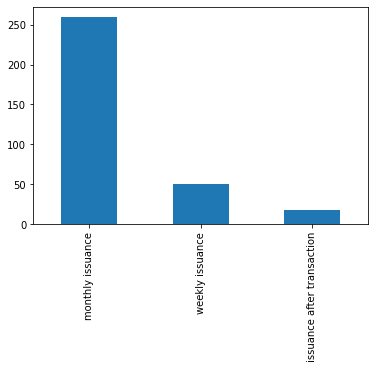

In [27]:
complete['frequency'].value_counts().plot(kind='bar')

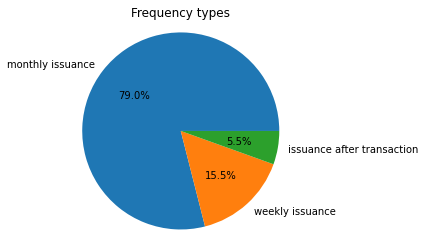

In [28]:
fig, ax = plt.subplots()
ax.pie(complete['frequency'].value_counts(), labels=complete['frequency'].unique(), autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Frequency types')

plt.show()

#### Remarks:
Of the 328 rows of complete data available, the majority corresponds to accounts where the frequency attribute value is 'monthly issuance'. 'monthly issuance' has 5 times more entries than 'weekly issuance' and more than 14 times more entries than 'issuance after transaction'.

This might mean that this attribute will not be of great help to predict the outcome of a loan due to the small sample of the other 2 possibilities.

### 1.4.2 Account Creation Date - Date Attribute

In [29]:
complete['acc date'].describe()

count                     328
unique                    286
top       1993-11-26 00:00:00
freq                        4
first     1993-01-13 00:00:00
last      1996-06-25 00:00:00
Name: acc date, dtype: object

In [30]:
print("Min: ", end="");                 print(complete['acc date'].min())
print("Max: ", end="");                 print(complete['acc date'].max())

Min: 1993-01-13 00:00:00
Max: 1996-06-25 00:00:00


<AxesSubplot:>

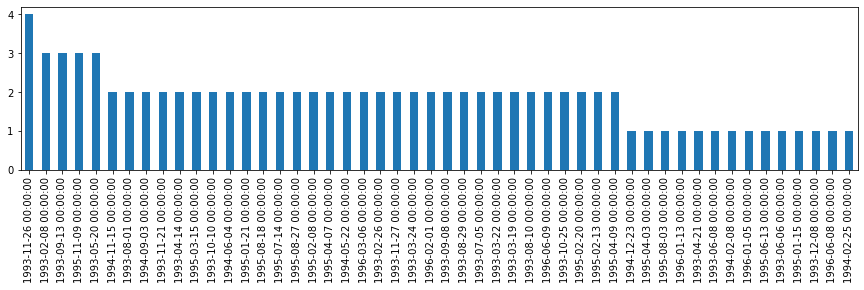

In [31]:
complete['acc date'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:
The accounts of this dataset were all created between the years 1993 and 1996.

The date of account creation a priori doesn't seem to be related at all with the possible outcome of a loan.

### 1.4.3 Number of transactions - Numerical Attribute

In [32]:
q3, q1 = np.percentile(complete['# trans'], [75 ,25])

print("Min: ", end="");                 print(complete['# trans'].min())
print("Max: ", end="");                 print(complete['# trans'].max())
print("Mean: ", end="");                print(complete['# trans'].mean())
print("Median: ", end="");              print(complete['# trans'].median())
print("Standard deviation: ", end="");  print(complete['# trans'].std())
print("Skewness: ", end="");            print(complete['# trans'].skew())  
print("Variance: ", end="");            print(complete['# trans'].var())
print("Kurtosis: ", end="");            print(complete['# trans'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 4.0
Max: 196.0
Mean: 74.67682926829268
Median: 69.0
Standard deviation: 44.84385904325418
Skewness: 0.5601362519038949
Variance: 2010.9716938912497
Kurtosis: -0.44042695234757234
Interquartile Range: 64.5 | Q1: 39.0 | Q3: 103.5


<AxesSubplot:xlabel='# trans', ylabel='Density'>

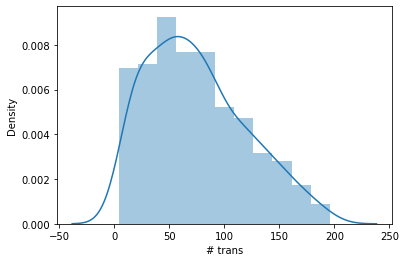

In [33]:
sns.distplot(complete['# trans'])

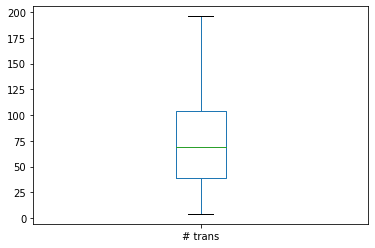

In [34]:
complete['# trans'].plot.box();

#### Remarks:
The number of transactions performed by an account has a very wide range of values and every single one is at minimum 4 and at maximum 196 which justifies the high variance / standard deviation. The majority of the values is concentrated in the range \[39,103\].
By observing the skewness we can classify the data as slightly skewed (between -0.5 and 0.5 would be considered approximately symmetric). The small (in absolute value) kurtosis (it is in the range \[-1,1\]) informs that the distribution is neither too flat or too peeked.

### 1.4.4 Transaction Operations - Numerical Attributes

oper #1    13.737805
oper #2     0.070122
oper #3     3.472561
oper #4     9.246951
oper #5    34.945122
dtype: float64


<AxesSubplot:title={'center':'Average number of transactions per Operation'}>

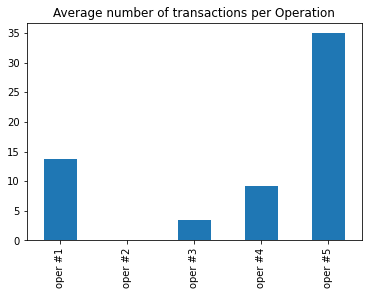

In [35]:
subset = complete[['oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5']].mean()
print(subset)
subset.plot(kind='bar', title="Average number of transactions per Operation")

#### Remarks:
The data provided is very unbalanced when it comes to the transaction operations' performed for each account of which there is information about a loan. Of the 5 options identified, 'oper \#5' ('withdrawal in cash') is by far the most common while 'oper \#2' ('credit card withdrawal') is very rare.

Therefore, this attribute might not be of much use to predict the outcome of a loan due to sample size discrepancy of the 5 possible values.

### 1.4.5 Transaction Types - Numerical Attributes

<AxesSubplot:title={'center':'Average number of transactions per Type'}>

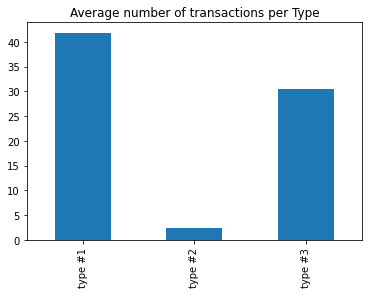

In [36]:
subset = complete[['type #1', 'type #2', 'type #3']].mean()
subset.plot(kind='bar', title="Average number of transactions per Type")

#### Remarks: 
Similar to columns 'oper X' with the difference that in this case only one value is much less represented than the others
Therefore, similarly to the previous attribute, this one might also not be of much use to predict the outcome of a loan due to sample size of 1 of the possible values.

### 1.4.6 Average Transaction Amount - Numerical Attribute

In [37]:
q3, q1 = np.percentile(complete['avg trans amount'], [75 ,25])

print("Min: ", end="");                 print(complete['avg trans amount'].min())
print("Max: ", end="");                 print(complete['avg trans amount'].max())
print("Mean: ", end="");                print(complete['avg trans amount'].mean())
print("Median: ", end="");              print(complete['avg trans amount'].median())
print("Standard deviation: ", end="");  print(complete['avg trans amount'].std())
print("Skewness: ", end="");            print(complete['avg trans amount'].skew())  
print("Variance: ", end="");            print(complete['avg trans amount'].var())
print("Kurtosis: ", end="");            print(complete['avg trans amount'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

Min: 1577.49
Max: 24948.66
Mean: 9533.910853658534
Median: 9058.369999999999
Standard deviation: 4221.392841211061
Skewness: 0.4365405908730615
Variance: 17820157.519827995
Kurtosis: -0.1450695339199779
Interquartile Range: 6406.2125000000015 | Q1: 6281.674999999999 | Q3: 12687.8875


<AxesSubplot:xlabel='avg trans amount', ylabel='Density'>

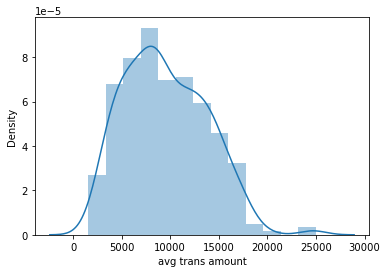

In [38]:
sns.distplot(complete['avg trans amount'])

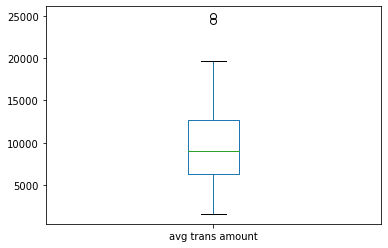

In [39]:
complete['avg trans amount'].plot.box();

#### Remarks:
The 'average transaction amount' atribute seems to follow approximately a normal distribution based on its graphical representation and skewness/kurtosis values.

Despite this, it is possible to identify some values outside the general landscape that can either correspond to outliers or to a real group that is not well represented in the provided data.

### 1.4.7 Average Transaction Balance - Numerical Attribute

In [40]:
q3, q1 = np.percentile(complete['avg trans balance'], [75 ,25])

print("Min: ", end="");                 print(complete['avg trans balance'].min())
print("Max: ", end="");                 print(complete['avg trans balance'].max())
print("Mean: ", end="");                print(complete['avg trans balance'].mean())
print("Median: ", end="");              print(complete['avg trans balance'].median())
print("Standard deviation: ", end="");  print(complete['avg trans balance'].std())
print("Skewness: ", end="");            print(complete['avg trans balance'].skew())  
print("Variance: ", end="");            print(complete['avg trans balance'].var())
print("Kurtosis: ", end="");            print(complete['avg trans balance'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

Min: 12250.0
Max: 76232.7
Mean: 43292.897073170745
Median: 42183.6
Standard deviation: 13280.435568131155
Skewness: 0.23392463495485247
Variance: 176369968.8792831
Kurtosis: -0.7022089895996433
Interquartile Range: 20420.417500000003 | Q1: 32592.165 | Q3: 53012.582500000004


<AxesSubplot:xlabel='avg trans balance', ylabel='Density'>

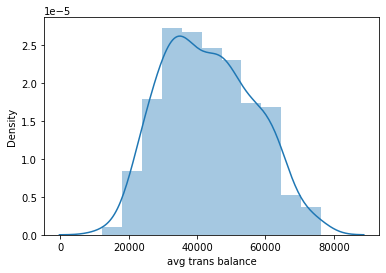

In [41]:
sns.distplot(complete['avg trans balance'])

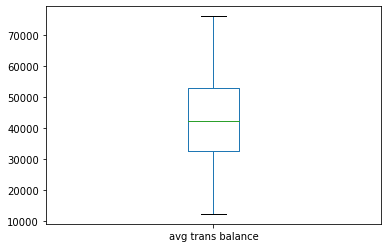

In [42]:
complete['avg trans balance'].plot.box();

#### Remarks:
Like the previous atribute, the 'average transaction balance' seems to follow approximately a normal distribution based on its graphical representation and skewness/kurtosis values. Contrasting with the last atribute, there seem to be no possible outliers, constituting possibly a good candidate variable to predict the outcome of a loan.

### 1.4.8 Loan Date - Date Attribute

In [43]:
complete['loan date'].describe()

count                     328
unique                    283
top       1994-12-21 00:00:00
freq                        3
first     1993-07-05 00:00:00
last      1996-12-27 00:00:00
Name: loan date, dtype: object

In [44]:
print("Min: ", end="");                 print(complete['loan date'].min())
print("Max: ", end="");                 print(complete['loan date'].max())

Min: 1993-07-05 00:00:00
Max: 1996-12-27 00:00:00


<AxesSubplot:>

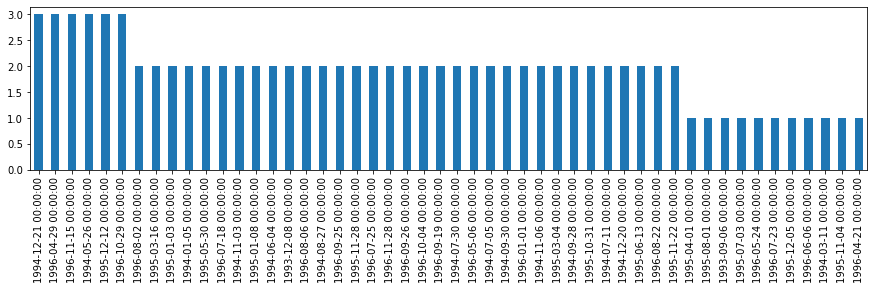

In [45]:
complete['loan date'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:
The loan of this dataset all date between the years 1993 and 1996, similarly to the account creation dates.

The date of a loan, a priori, doesn't seem to be related at all with the possible outcome of a loan.

In [46]:
q3, q1 = np.percentile(complete['age_at_loan'], [75 ,25])

print("Min: ", end="");                 print(complete['age_at_loan'].min())
print("Max: ", end="");                 print(complete['age_at_loan'].max())
print("Mean: ", end="");                print(complete['age_at_loan'].mean())
print("Median: ", end="");              print(complete['age_at_loan'].median())
print("Standard deviation: ", end="");  print(complete['age_at_loan'].std())
print("Skewness: ", end="");            print(complete['age_at_loan'].skew())  
print("Variance: ", end="");            print(complete['age_at_loan'].var())
print("Kurtosis: ", end="");            print(complete['age_at_loan'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 13.574264202600958
Max: 60.815879534565376
Mean: 36.25369359443081
Median: 35.51129363449692
Standard deviation: 12.544874165561444
Skewness: 0.09356797458962429
Variance: 157.37386782977094
Kurtosis: -1.1047773022669136
Interquartile Range: 21.28268309377139 | Q1: 25.446954140999317 | Q3: 46.729637234770706


In [149]:
ages_distribution = complete.loc[complete['age_at_loan'] < 17]
#print(ages_distribution.shape[0])
print(complete.shape[0])
ages_distribution

#sns.distplot(complete['age_at_loan'])

#complete['age_at_loan'].hist(bins=20)

#fig, ax = plt.subplots()
#fig.set_size_inches(10,8)
#sns.histplot(complete['age_at_loan'], ax=ax)  # distplot is deprecate and replaced by histplot
#ax.set_xlim(15,70)
#ax.set_xticks(range(13,70, 1))
#plt.show()

#complete['age_at_loan'].hist()

328


,loan status,frequency,acc date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan date,loan amount,loan duration (mths),loan payments,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,card type,birthdate,sex,has disponent,age_at_loan,acc_age_at_loan,unemploymant rate,no. of commited crimes per capita
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5593,-1,monthly issuance,1994-05-26,117.0,26.0,0.0,0.0,0.0,71.0,70.0,1.0,46.0,10720.31,46487.00,1996-04-18,277884,36,7719,105606,77,26,7,2,7,53.0,8254,97,None,1980-09-17,F,False,15.583847,1.897331,3.275,0.021263
6019,1,monthly issuance,1995-08-03,77.0,18.0,0.0,0.0,23.0,25.0,48.0,0.0,29.0,2434.24,27533.66,1996-07-25,11400,12,950,387570,0,0,0,1,1,100.0,9897,140,None,1980-04-30,F,False,16.235455,0.977413,1.780,0.048271
7104,1,monthly issuance,1993-07-11,17.0,1.0,0.0,5.0,1.0,6.0,7.0,0.0,10.0,13038.09,45198.15,1993-12-13,259740,60,4329,228848,15,40,18,2,6,57.2,9893,96,None,1979-03-16,M,False,14.746064,0.424367,4.405,0.025148
5449,1,monthly issuance,1994-12-09,52.0,14.0,0.0,0.0,6.0,22.0,28.0,0.0,24.0,4348.37,27019.57,1995-11-04,99336,24,4139,228848,15,40,18,2,6,57.2,9893,96,None,1980-07-09,F,False,15.321013,0.903491,4.405,0.025148
7004,1,monthly issuance,1993-08-21,119.0,22.0,0.0,0.0,28.0,51.0,79.0,0.0,40.0,7321.52,36942.00,1995-03-15,331560,60,5526,107870,84,29,6,1,6,58.0,8754,137,None,1980-11-23,M,True,14.305270,1.563313,4.070,0.035561
7271,1,monthly issuance,1994-11-24,143.0,2.0,0.0,22.0,18.0,79.0,88.0,9.0,46.0,12882.52,57131.74,1996-10-02,392460,60,6541,107870,84,29,6,1,6,58.0,8754,137,None,1980-11-13,F,True,15.885010,1.856263,4.070,0.035561
6888,1,monthly issuance,1993-02-04,115.0,21.0,0.0,0.0,23.0,39.0,62.0,0.0,53.0,8275.28,48944.83,1994-07-11,39576,12,3298,1204953,0,0,0,1,1,100.0,12541,167,None,1980-05-02,F,False,14.190281,1.429158,0.360,0.076677
7240,1,weekly issuance,1993-02-14,27.0,1.0,0.0,6.0,3.0,11.0,14.0,0.0,13.0,18945.97,57188.21,1993-09-06,274740,60,4579,1204953,0,0,0,1,1,100.0,12541,167,None,1978-09-07,M,False,14.997947,0.558522,0.360,0.076677
6698,1,weekly issuance,1995-08-08,50.0,11.0,0.0,0.0,6.0,21.0,25.0,2.0,23.0,12112.08,60054.73,1996-03-10,247728,48,5161,1204953,0,0,0,1,1,100.0,12541,167,None,1979-06-19,M,False,16.725530,0.588638,0.360,0.076677


<AxesSubplot:>

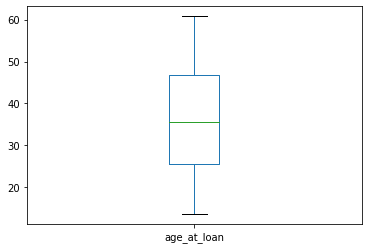

In [48]:
complete['age_at_loan'].plot.box()

#### Remarks:
The range of ages of the clients at the time at which the loan was provided is quite comprehensive.
The skewness indicates a distribution of the data that isn't skewed and the kurtosis points to its flatness, as it is possible to confirm by observation of the distplot.

Despite this aparent 'normality' and, by extent, possibly usefulness of this atribute it is also possible to detect that some values and under the minimum adult age (18 years) which would make these entries invalid and, therefore, creating the necessity to remove them before further analysis.

### 1.4.9 Loan Amount - Numerical Attribute

In [49]:
q3, q1 = np.percentile(complete['loan amount'], [75 ,25])

print("Min: ", end="");                 print(complete['loan amount'].min())
print("Max: ", end="");                 print(complete['loan amount'].max())
print("Mean: ", end="");                print(complete['loan amount'].mean())
print("Median: ", end="");              print(complete['loan amount'].median())
print("Standard deviation: ", end="");  print(complete['loan amount'].std())
print("Skewness: ", end="");            print(complete['loan amount'].skew())  
print("Variance: ", end="");            print(complete['loan amount'].var())
print("Kurtosis: ", end="");            print(complete['loan amount'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# Very High std which indicates that the data is spread out and not clustered around the mean
# > 1 therefore it is skewed to the right

Min: 4980
Max: 538500
Mean: 145308.6219512195
Median: 114804.0
Standard deviation: 105247.31809757085
Skewness: 1.0811084015092238
Variance: 11076997966.731266
Kurtosis: 0.8306938043642567
Interquartile Range: 130272.0 | Q1: 68328.0 | Q3: 198600.0


<AxesSubplot:xlabel='loan amount', ylabel='Density'>

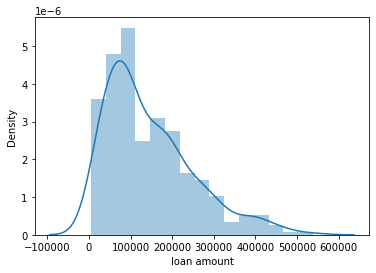

In [50]:
sns.distplot(complete['loan amount'])

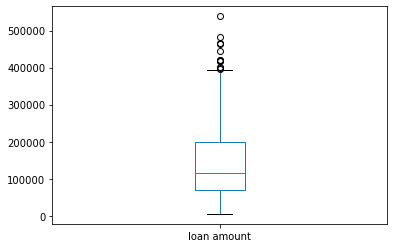

In [51]:
complete['loan amount'].plot.box();

#### Remarks:
The loan amount column data is made of very different values and it is skewed to the right which is confirmed by the skewness. The kurtosis can be confirmed by observation of the seaborn distplot that shows a peak around the value 100000.

It is possible to identify some values outside the general landscape that can either correspond to outliers or to a real group that is not well represented in the provided data. Due to the number of these values we assume the second hypotesis.

### 1.4.10 Loan Duration (in months) - Numerical Attribute

In [52]:
q3, q1 = np.percentile(complete['loan duration (mths)'], [75 ,25])

print("Min: ", end="");                 print(complete['loan duration (mths)'].min())
print("Max: ", end="");                 print(complete['loan duration (mths)'].max())
print("Mean: ", end="");                print(complete['loan duration (mths)'].mean())
print("Median: ", end="");              print(complete['loan duration (mths)'].median())
print("Standard deviation: ", end="");  print(complete['loan duration (mths)'].std())
print("Skewness: ", end="");            print(complete['loan duration (mths)'].skew())  
print("Variance: ", end="");            print(complete['loan duration (mths)'].var())
print("Kurtosis: ", end="");            print(complete['loan duration (mths)'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 12
Max: 60
Mean: 35.853658536585364
Median: 36.0
Standard deviation: 16.734751661727223
Skewness: 0.05589223008522363
Variance: 280.05191317968206
Kurtosis: -1.2671912803874055
Interquartile Range: 24.0 | Q1: 24.0 | Q3: 48.0


<AxesSubplot:>

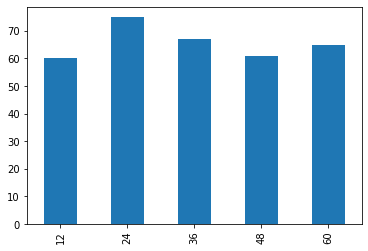

In [53]:
complete['loan duration (mths)'].value_counts().sort_index().plot(kind='bar')

#### Remarks:
In general, the loan duration data seems rather uniform visually, which is in agreement with the statistical analysis results: small absolute value of skewness points to a approximately normal distribution and the lower than -1 kurtosis represents a flat distribution.

Due to the very small variation in frequency of each of the values of this loan duration column, it is plausible to think it won't provide much information regarding the prediction of the outcome of a loan.

### 1.4.11 Loan Payments - Numerical Attribute

In [54]:
q3, q1 = np.percentile(complete['loan payments'], [75 ,25])

print("Min: ", end="");                 print(complete['loan payments'].min())
print("Max: ", end="");                 print(complete['loan payments'].max())
print("Mean: ", end="");                print(complete['loan payments'].mean())
print("Median: ", end="");              print(complete['loan payments'].median())
print("Standard deviation: ", end="");  print(complete['loan payments'].std())
print("Skewness: ", end="");            print(complete['loan payments'].skew())  
print("Variance: ", end="");            print(complete['loan payments'].var())
print("Kurtosis: ", end="");            print(complete['loan payments'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 319
Max: 9689
Mean: 4150.932926829269
Median: 3878.5
Standard deviation: 2193.620988539041
Skewness: 0.26933938573516064
Variance: 4811973.041358998
Kurtosis: -0.8465605235895723
Interquartile Range: 3539.0 | Q1: 2368.75 | Q3: 5907.75


<AxesSubplot:xlabel='loan payments', ylabel='Density'>

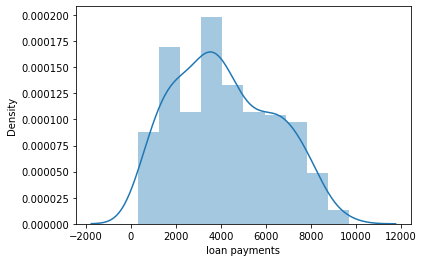

In [55]:
sns.distplot(complete['loan payments'])

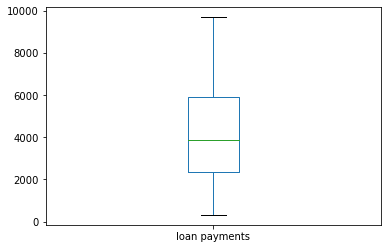

In [56]:
complete['loan payments'].plot.box();

#### Remarks:
Similarly to some of the previous atributes, loan payments follows approximately a normal distribution.
Besides, in some way seems to be in agreement with the loan amount atribute, as expected.

### 1.4.12 Loan Status - Nominal(?) Attribute

In [57]:
complete['loan status'].describe()

count    328.000000
mean       0.719512
std        0.695541
min       -1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: loan status, dtype: float64

<AxesSubplot:title={'center':'Loan Status Distribution'}>

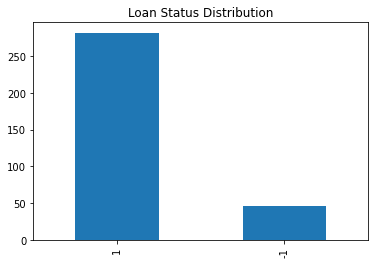

In [58]:
# -1 -> not paid; 1 -> paid
complete['loan status'].value_counts().plot(kind='bar', title="Loan Status Distribution")

#### Remarks:
By observation alone it is clear that the amount of loans where an account fulfills its commitments to the bank severely surpasses the number of entries where default credit it the result. Then, oversampling/undersampling methods might useful.

### 1.4.13 Number of district inhabitants - Numerical Attribute

In [59]:
q3, q1 = np.percentile(complete['no. of inhabitants'], [75 ,25])

print("Min: ", end="");                 print(complete['no. of inhabitants'].min())
print("Max: ", end="");                 print(complete['no. of inhabitants'].max())
print("Mean: ", end="");                print(complete['no. of inhabitants'].mean())
print("Median: ", end="");              print(complete['no. of inhabitants'].median())
print("Standard deviation: ", end="");  print(complete['no. of inhabitants'].std())
print("Skewness: ", end="");            print(complete['no. of inhabitants'].skew())  
print("Variance: ", end="");            print(complete['no. of inhabitants'].var())
print("Kurtosis: ", end="");            print(complete['no. of inhabitants'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 42821
Max: 1204953
Mean: 288846.6981707317
Median: 125236.0
Standard deviation: 377966.15558948106
Skewness: 1.9275643050143925
Variance: 142858414771.0918
Kurtosis: 1.9645163409272448
Interquartile Range: 134719.5 | Q1: 92084.0 | Q3: 226803.5


<AxesSubplot:xlabel='no. of inhabitants', ylabel='Density'>

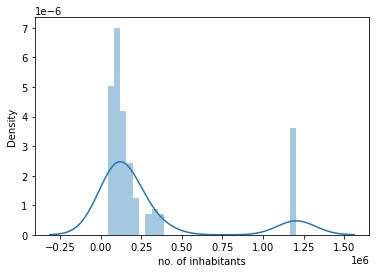

In [60]:
sns.distplot(complete['no. of inhabitants'])

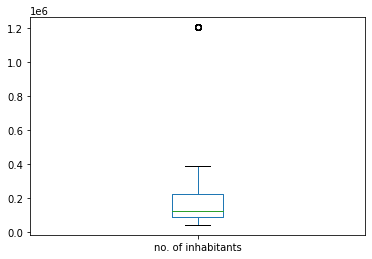

In [61]:
complete['no. of inhabitants'].plot.box();

#### Remarks:
Without the data past 750 thousand inhabitants, the atribute would assume almost a perfect normal distribution. As is, the data distribution is substantially skewed and the kurtosis confirms the peaked characterization.
Due to the percentage of information that fits in the supposed 'outlier zone', these entries can't be considered outliers. They may just represent a densely populated area where the average corresponds to semi-urban or even rural regions and the provided data simply doesn't have information regarding regions whose population numbers fit the \[400000, 1100000\] range.

### 1.4.14 Inahbitants per municipality - Numerical Attribute

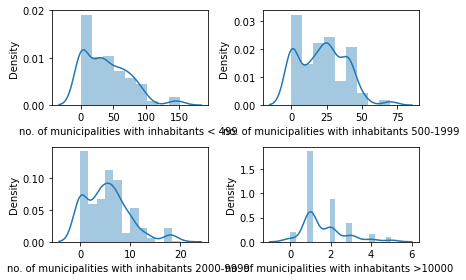

In [62]:
fig, ax = plt.subplots(2,2)
sns.distplot(complete['no. of municipalities with inhabitants < 499 '], ax=ax[0][0])
sns.distplot(complete['no. of municipalities with inhabitants 500-1999'], ax=ax[0][1])

sns.distplot(complete['no. of municipalities with inhabitants 2000-9999 '], ax=ax[1][0])
sns.distplot(complete['no. of municipalities with inhabitants >10000 '], ax=ax[1][1])
fig.tight_layout()
fig.show()

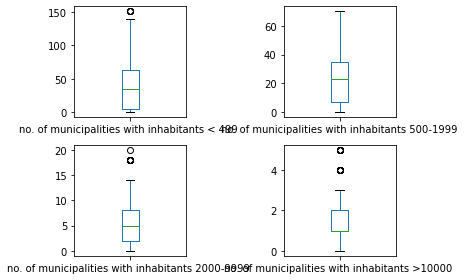

In [63]:
complete[['no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ']].plot(kind='box', subplots=True, legend=False, layout=(2, 2))
plt.tight_layout()

#### Remarks:
The distributions of the number of municipalities seem very disperse and with aparent low value by themselves for loan predictions. Nonetheless, it can be especulated that many of the accounts belong to people that live in a far more densely populated area that the rest, hyposthesis that is corroborated by the previous and next data regarding the districts.

### 1.4.15 Number of cities of district - Numerical Attribute

In [64]:
q3, q1 = np.percentile(complete['no. of cities '], [75 ,25])

print("Min: ", end="");                 print(complete['no. of cities '].min())
print("Max: ", end="");                 print(complete['no. of cities '].max())
print("Mean: ", end="");                print(complete['no. of cities '].mean())
print("Median: ", end="");              print(complete['no. of cities '].median())
print("Standard deviation: ", end="");  print(complete['no. of cities '].std())
print("Skewness: ", end="");            print(complete['no. of cities '].skew())  
print("Variance: ", end="");            print(complete['no. of cities '].var())
print("Kurtosis: ", end="");            print(complete['no. of cities '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 1
Max: 11
Mean: 5.219512195121951
Median: 5.0
Standard deviation: 2.8863249873450734
Skewness: -0.01195801679483785
Variance: 8.330871932572538
Kurtosis: -0.9696877864885023
Interquartile Range: 3.0 | Q1: 4.0 | Q3: 7.0


<AxesSubplot:>

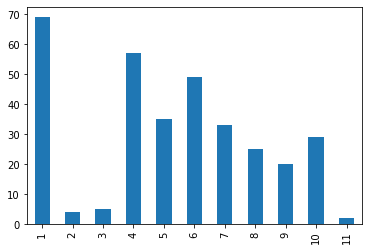

In [65]:
complete['no. of cities '].value_counts().sort_index().plot(kind='bar')

<AxesSubplot:xlabel='no. of cities ', ylabel='Density'>

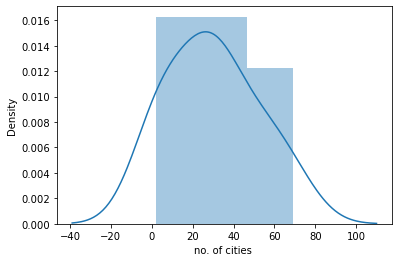

In [66]:
sns.distplot(complete['no. of cities '].value_counts())

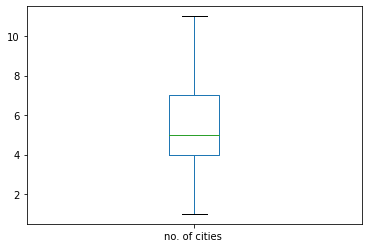

In [67]:
complete['no. of cities '].plot.box();

#### Remarks:
Aproximately a normal distribution.
This data doesn't seem to indicate any anomaly that might skew the outcome of a loan.

### 1.4.16 Ratio of Urban Inhabitants - Numerical Attribute

In [68]:
q3, q1 = np.percentile(complete['ratio of urban inhabitants '], [75 ,25])

print("Min: ", end="");                 print(complete['ratio of urban inhabitants '].min())
print("Max: ", end="");                 print(complete['ratio of urban inhabitants '].max())
print("Mean: ", end="");                print(complete['ratio of urban inhabitants '].mean())
print("Median: ", end="");              print(complete['ratio of urban inhabitants '].median())
print("Standard deviation: ", end="");  print(complete['ratio of urban inhabitants '].std())
print("Skewness: ", end="");            print(complete['ratio of urban inhabitants '].skew())  
print("Variance: ", end="");            print(complete['ratio of urban inhabitants '].var())
print("Kurtosis: ", end="");            print(complete['ratio of urban inhabitants '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 33.9
Max: 100.0
Mean: 68.64939024390249
Median: 62.0
Standard deviation: 20.57345457783414
Skewness: 0.3407628249222313
Variance: 423.2670332662046
Kurtosis: -1.166292715416102
Interquartile Range: 35.25 | Q1: 53.0 | Q3: 88.25


<AxesSubplot:xlabel='ratio of urban inhabitants ', ylabel='Density'>

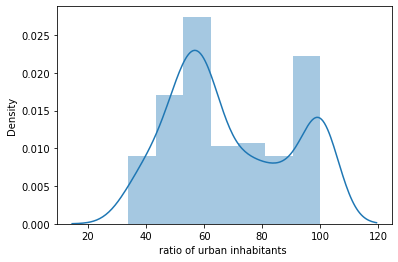

In [69]:
sns.distplot(complete['ratio of urban inhabitants '])

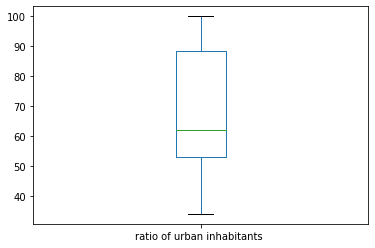

In [70]:
complete['ratio of urban inhabitants '].plot.box();

#### Remarks:
The range of districts' ratio of urban inhabitants is very wide. The provided information regarding people that took loans points to 2 concentrations: in districts where the urban inhabitants constitute either 50 or 100 percent of the population. Due to these 2 spikes, the skewness and kurtosis conclude an approximate normal and flat distribution of the data.

### 1.4.17 Average Salary - Numerical Attribute

In [71]:
q3, q1 = np.percentile(complete['average salary '], [75 ,25])

print("Min: ", end="");                 print(complete['average salary '].min())
print("Max: ", end="");                 print(complete['average salary '].max())
print("Mean: ", end="");                print(complete['average salary '].mean())
print("Median: ", end="");              print(complete['average salary '].median())
print("Standard deviation: ", end="");  print(complete['average salary '].std())
print("Skewness: ", end="");            print(complete['average salary '].skew())  
print("Variance: ", end="");            print(complete['average salary '].var())
print("Kurtosis: ", end="");            print(complete['average salary '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 8110
Max: 12541
Mean: 9593.338414634147
Median: 9019.5
Standard deviation: 1359.2325765121705
Skewness: 1.2456934836516622
Variance: 1847513.197051913
Kurtosis: 0.3720189164351839
Interquartile Range: 1399.0 | Q1: 8552.25 | Q3: 9951.25


<AxesSubplot:>

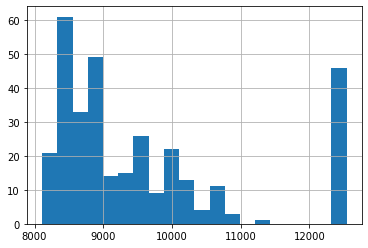

In [72]:
# sns.distplot(complete['average salary '])
complete['average salary '].hist(bins=20)

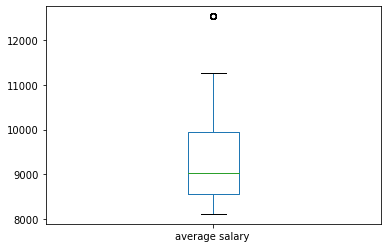

In [73]:
complete['average salary '].plot.box();

#### Remarks:
The average salary atribute seems to follow graphically a distribution somewhat similar to the ratio or urban inhabitants. The second 'spike' in this column could be taken as outlier because it is separated from the rest, which is not an option because of the percentage of the entries that it represents.

### 1.4.18 Unemploymant Rate - Numerical Attribute

In [74]:
#complete.loc[complete["unemploymant rate '95 "] == '?', "unemploymant rate '95 "] = complete["unemploymant rate '96 "]
#complete.loc[complete["unemploymant rate '96 "] == '?', "unemploymant rate '96 "] = complete["unemploymant rate '95 "]

#### Obtain the average of 95' and 96' columns

In [75]:
#complete["unemploymant rate"] = (complete["unemploymant rate '95 "].astype('float') + complete["unemploymant rate '96 "].astype('float')) / 2.0
#complete = complete.drop(columns=["unemploymant rate '95 ", "unemploymant rate '96 "])
# complete

In [76]:
q3, q1 = np.percentile(complete['unemploymant rate'], [75 ,25])

print("Min: ", end="");                 print(complete['unemploymant rate'].min())
print("Max: ", end="");                 print(complete['unemploymant rate'].max())
print("Mean: ", end="");                print(complete['unemploymant rate'].mean())
print("Median: ", end="");              print(complete['unemploymant rate'].median())
print("Standard deviation: ", end="");  print(complete['unemploymant rate'].std())
print("Skewness: ", end="");            print(complete['unemploymant rate'].skew())  
print("Variance: ", end="");            print(complete['unemploymant rate'].var())
print("Kurtosis: ", end="");            print(complete['unemploymant rate'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 0.36
Max: 8.370000000000001
Mean: 3.18169207317073
Median: 3.03
Standard deviation: 2.087088556313355
Skewness: 0.48722269217724207
Variance: 4.355938641894165
Kurtosis: -0.46413878279738796
Interquartile Range: 2.7149999999999994 | Q1: 1.69 | Q3: 4.404999999999999


<AxesSubplot:xlabel='unemploymant rate', ylabel='Density'>

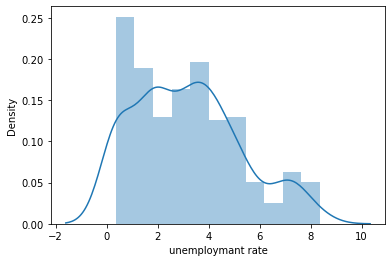

In [77]:
sns.distplot(complete['unemploymant rate'])

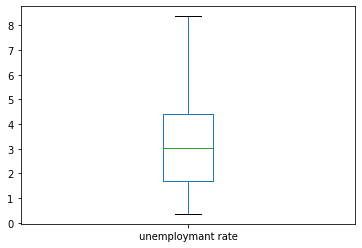

In [78]:
complete['unemploymant rate'].plot.box();

#### Remarks:
The unemploymant rate seems to follow a normal distribution and doesn't have any outliers.

### 1.4.19 Number of enterpreneurs per 1000 inhabitants - Numerical Attribute

In [79]:
q3, q1 = np.percentile(complete['no. of enterpreneurs per 1000 inhabitants '], [75 ,25])

print("Min: ", end="");                 print(complete['no. of enterpreneurs per 1000 inhabitants '].min())
print("Max: ", end="");                 print(complete['no. of enterpreneurs per 1000 inhabitants '].max())
print("Mean: ", end="");                print(complete['no. of enterpreneurs per 1000 inhabitants '].mean())
print("Median: ", end="");              print(complete['no. of enterpreneurs per 1000 inhabitants '].median())
print("Standard deviation: ", end="");  print(complete['no. of enterpreneurs per 1000 inhabitants '].std())
print("Skewness: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].skew())  
print("Variance: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].var())
print("Kurtosis: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 81
Max: 167
Mean: 122.75914634146342
Median: 115.5
Standard deviation: 23.951657004791027
Skewness: 0.5916848426357383
Variance: 573.6818732751551
Kurtosis: -0.6495980694707746
Interquartile Range: 33.0 | Q1: 107.0 | Q3: 140.0


<AxesSubplot:xlabel='no. of enterpreneurs per 1000 inhabitants ', ylabel='Density'>

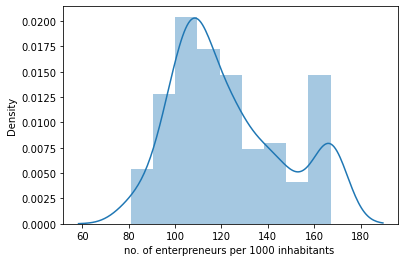

In [80]:
sns.distplot(complete['no. of enterpreneurs per 1000 inhabitants '])

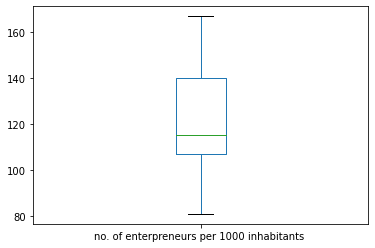

In [81]:
complete['no. of enterpreneurs per 1000 inhabitants '].plot.box();

#### Remarks:
Interestingly, the number of enterpreneurs per 1000 inhabitants follows a distribution practically identical to the ratio of urban inhabitants and average salary, which may represent that some of the columns regarding district data might be redundant.

### 1.4.20 Number of commited crimes per capita - Numerical Attribute

In [82]:
#complete.loc[complete["no. of commited crimes '95 "] == '?', "no. of commited crimes '95 "] = complete["no. of commited crimes '96 "]
#complete.loc[complete["no. of commited crimes '96 "] == '?', "no. of commited crimes '96 "] = complete["no. of commited crimes '95 "]

#### Obtain the average of 95' and 96' columns and then divide by the number of inhabitants

In [83]:
#complete["no. of commited crimes per capita"] = (complete["no. of commited crimes '95 "].astype('float') + complete["no. of commited crimes '96 "].astype('float')) / 2.0 / complete["no. of inhabitants"]
#complete = complete.drop(columns=["no. of commited crimes '95 ", "no. of commited crimes '96 "])
# complete

<AxesSubplot:xlabel='no. of commited crimes per capita', ylabel='Density'>

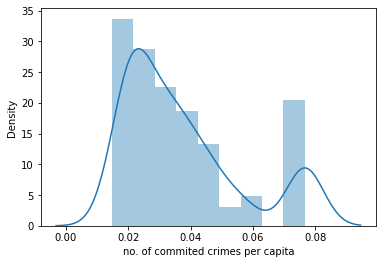

In [84]:
sns.distplot(complete['no. of commited crimes per capita'])

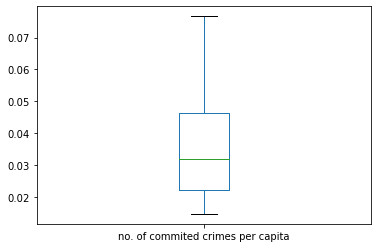

In [85]:
complete['no. of commited crimes per capita'].plot.box();

#### Remarks:
The number of crimes per capita follows the general district data distribution. One peculiarity by 'crossing data' is that the second spike in this case corresponds to places with higher numbers of inhabitants.

### 1.4.21 Card Type - Numerical Attribute

In [86]:
complete['card type'].describe()

count      328
unique       4
top       None
freq       317
Name: card type, dtype: object

<AxesSubplot:>

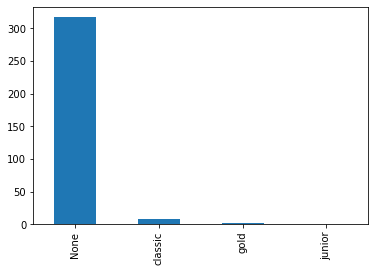

In [87]:
complete['card type'].value_counts().plot(kind='bar')

#### Filling Missing Values with 'None'

In [88]:
#complete['card type'] = complete['card type'].fillna('None')

In [89]:
complete['card type'].value_counts()

None       317
classic      8
gold         2
junior       1
Name: card type, dtype: int64

In [90]:
complete['card type'].unique()

array(['None', 'gold', 'classic', 'junior'], dtype=object)

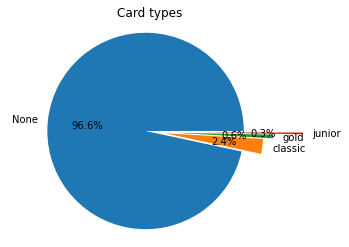

In [91]:
fig, ax = plt.subplots()
ax.pie(complete['card type'].value_counts(), labels=['None', 'classic', 'gold', 'junior'], autopct='%1.1f%%', explode = [0.1,0.1,0.2,0.5])
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Card types             ')

plt.show()

#### Remarks:
Missing values ('NaN') are infered to be 'no card existent' and therefore replaced by 'None' because in the 90s the popularity of the credit was still low.
Despite the very small amount of entries that have card data, this atribute can still be considered useful: for example, to have a card might lead to a higher chance to pay a loan.

### 1.4.22 Birthdate - Date Attribute

In [92]:
complete['birthdate'].describe()

count                     328
unique                    318
top       1945-02-04 00:00:00
freq                        2
first     1935-01-29 00:00:00
last      1980-12-07 00:00:00
Name: birthdate, dtype: object

In [93]:
print("Min: ", end="");                 print(complete['birthdate'].min())
print("Max: ", end="");                 print(complete['birthdate'].max())

Min: 1935-01-29 00:00:00
Max: 1980-12-07 00:00:00


<AxesSubplot:>

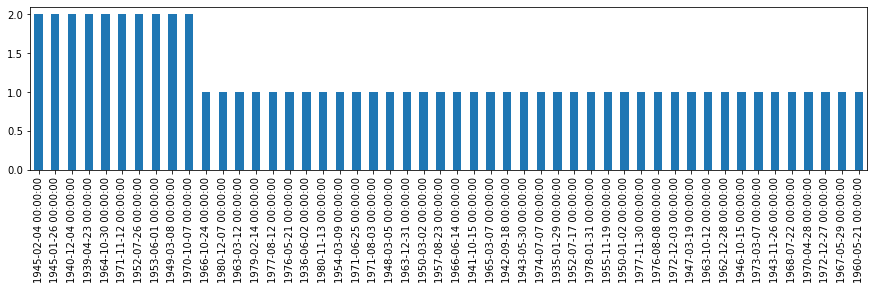

In [94]:
complete['birthdate'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:
The birthdate of an account owner, a priori, doesn't seem to be related at all with the possible outcome of a loan, but might be useful to detect anomalies like the possibility of an under 18 person to contract a loan which is invalid.

### 1.4.23 Client Sex - Nominal Categorical Attribute

In [95]:
complete['sex'].describe()

count     328
unique      2
top         M
freq      166
Name: sex, dtype: object

<AxesSubplot:>

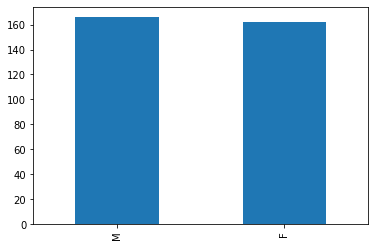

In [96]:
complete['sex'].value_counts().plot(kind='bar')

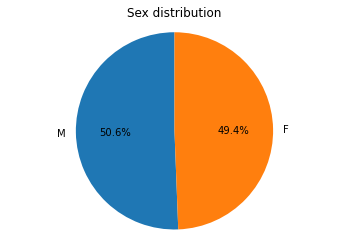

In [97]:
fig, ax = plt.subplots()
ax.pie(complete['sex'].value_counts(), labels=complete['sex'].unique(), autopct='%1.1f%%', startangle = 90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Sex distribution')

plt.show()

#### Remarks:
There isn't any unbalance in the total distribution of individuals regarding their sex which should lead to a plausible atribute for loan prediction.

### 1.4.23 Account has disponent or not - Nominal Categorical Attribute

In [98]:
complete['has disponent'].describe()

count       328
unique        2
top       False
freq        253
Name: has disponent, dtype: object

<AxesSubplot:>

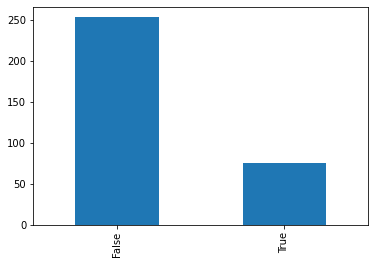

In [99]:
complete['has disponent'].value_counts().plot(kind='bar')

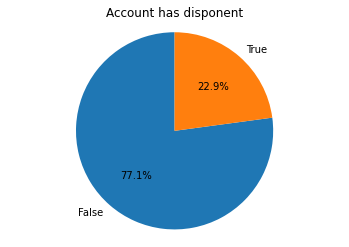

In [100]:
fig, ax = plt.subplots()
ax.pie(complete['has disponent'].value_counts(), labels=complete['has disponent'].unique(), autopct='%1.1f%%', startangle = 90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Account has disponent')

plt.show()

#### Remarks
Despite the frequency disparity between the two possible values, another person besides the owner associated with an account may imply a higher or lower chance of loan payment.

In [101]:
#complete.to_csv("./complete_data_comp_final_1.csv", sep=";")

In [102]:
#complete.loc[complete['age at loan (Years)'] < 18]

## 1.5 Multivariate Data Analysis of variability or dispersion

In [103]:
df_num = complete.select_dtypes(include = ['float64', 'int64'])
df_num.columns

Index(['loan status', '# trans', 'oper #1', 'oper #2', 'oper #3', 'oper #4',
       'oper #5', 'type #1', 'type #2', 'type #3', 'avg trans amount',
       'avg trans balance', 'loan amount', 'loan duration (mths)',
       'loan payments', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'age_at_loan',
       'acc_age_at_loan', 'unemploymant rate',
       'no. of commited crimes per capita'],
      dtype='object')

### 1.5.1 Covariance Matrix

<AxesSubplot:>

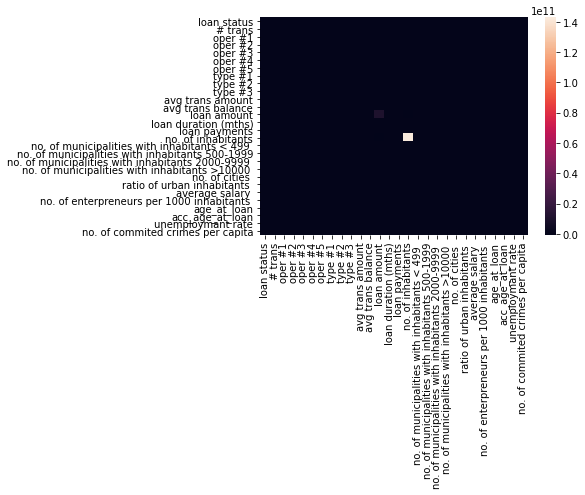

In [104]:
# plot the heatmap
sns.heatmap(df_num.cov(), 
        xticklabels=df_num.columns,
        yticklabels=df_num.columns)

#### Remarks

### 1.5.2 Correlation Matrix

#### 1.5.2.1 Pearson (standard correlation coefficient)

In [105]:
pearsoncorr = df_num.corr(method='pearson').round(2)
pearsoncorr

,loan status,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan amount,loan duration (mths),loan payments,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,age_at_loan,acc_age_at_loan,unemploymant rate,no. of commited crimes per capita
loan status,1.00,0.09,-0.05,0.05,0.14,0.18,0.06,0.13,-0.04,0.02,0.04,0.19,-0.13,-0.00,-0.17,-0.01,0.06,0.06,0.03,0.03,0.04,-0.02,0.02,0.02,-0.03,0.08,-0.00,-0.01
# trans,0.09,1.00,0.64,0.13,0.17,0.68,0.95,0.97,0.49,0.93,-0.11,0.14,0.03,0.02,0.01,-0.04,0.09,0.00,-0.01,-0.00,0.11,-0.00,-0.06,-0.00,-0.06,0.91,0.01,-0.05
oper #1,-0.05,0.64,1.00,0.04,-0.57,0.31,0.58,0.56,0.24,0.73,-0.11,0.10,0.04,0.07,-0.03,-0.01,0.03,-0.02,-0.03,0.00,0.08,0.06,-0.02,0.00,-0.05,0.56,0.03,-0.02
oper #2,0.05,0.13,0.04,1.00,0.02,0.18,0.08,0.16,0.03,0.06,-0.02,0.02,-0.02,0.04,-0.05,-0.04,0.04,0.06,0.08,-0.12,0.04,-0.08,-0.04,-0.07,-0.02,0.11,-0.00,-0.05
oper #3,0.14,0.17,-0.57,0.02,1.00,0.08,0.24,0.18,0.36,0.06,0.19,0.13,0.07,-0.05,0.12,-0.06,0.09,0.04,0.04,-0.03,0.04,-0.10,-0.06,-0.01,0.01,0.21,-0.04,-0.05
oper #4,0.18,0.68,0.31,0.18,0.08,1.00,0.45,0.79,0.08,0.45,-0.31,-0.12,-0.12,-0.03,-0.11,-0.02,0.05,-0.01,-0.01,0.05,0.03,0.01,-0.05,-0.04,-0.03,0.51,0.07,-0.01
oper #5,0.06,0.95,0.58,0.08,0.24,0.45,1.00,0.90,0.60,0.89,0.03,0.25,0.09,0.03,0.07,-0.05,0.10,0.01,-0.01,-0.03,0.11,-0.03,-0.07,-0.00,-0.06,0.92,-0.01,-0.06
type #1,0.13,0.97,0.56,0.16,0.18,0.79,0.90,1.00,0.38,0.83,-0.16,0.09,-0.00,0.02,-0.02,-0.04,0.09,0.00,-0.01,0.00,0.09,-0.01,-0.07,-0.02,-0.05,0.88,0.02,-0.04
type #2,-0.04,0.49,0.24,0.03,0.36,0.08,0.60,0.38,1.00,0.49,0.36,0.40,0.13,-0.07,0.22,-0.06,0.04,0.02,-0.00,-0.01,0.08,-0.05,-0.06,-0.04,-0.01,0.42,0.04,-0.06
type #3,0.02,0.93,0.73,0.06,0.06,0.45,0.89,0.83,0.49,1.00,-0.09,0.15,0.07,0.04,0.03,-0.03,0.07,-0.00,0.00,-0.01,0.12,0.03,-0.04,0.03,-0.05,0.87,-0.02,-0.04


<AxesSubplot:>

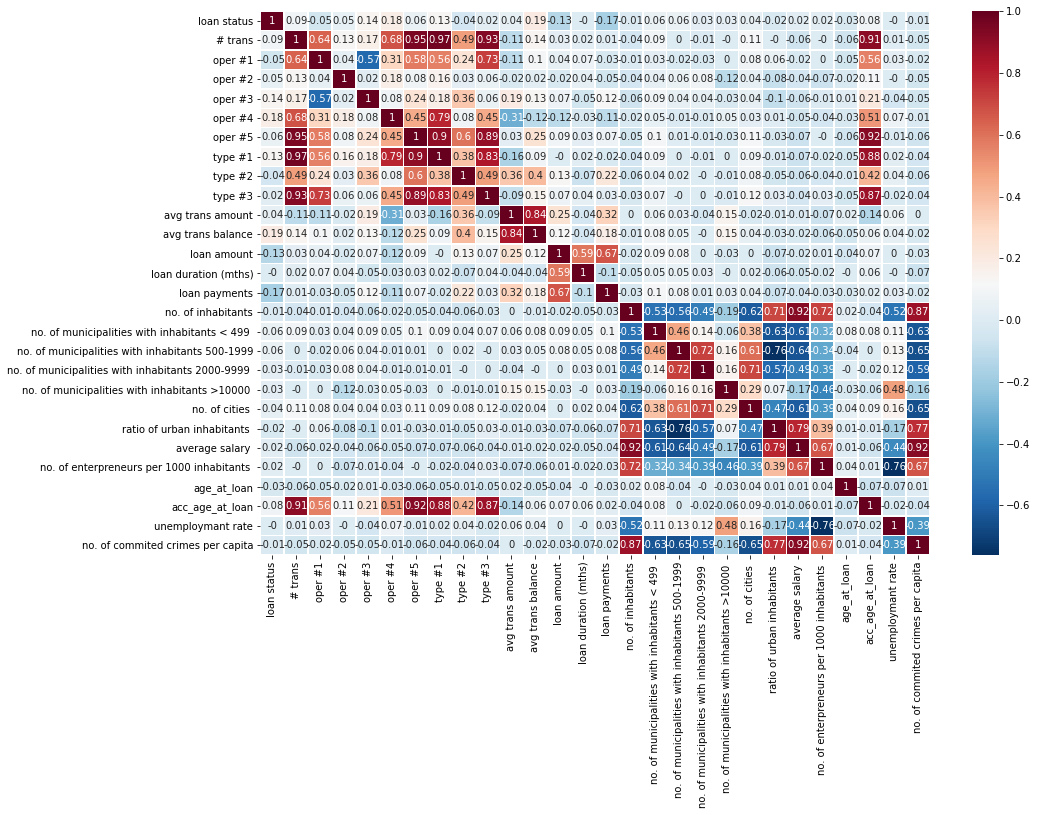

In [106]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            linewidth=0.5,
            annot=True,
            ax=ax)

In [107]:
complete['loan status'].corr(complete['average salary '])

0.02389526167761629

In [108]:
from scipy import stats

In [109]:
r, p = stats.pearsonr(complete['loan status'], complete['average salary '])
print(round(r, 4))
print(round(p, 4))

0.0239
0.6663


In [110]:
corr_df = pd.DataFrame(columns=['r', 'p'])

for col in complete:
    if pd.api.types.is_numeric_dtype(complete[col]) and col != 'loan status':
        r, p = stats.pearsonr(complete['loan status'], complete[col])
        corr_df.loc[col] = [round(r, 3), round(p, 3)]
    
corr_df

,r,p
# trans,0.091,0.099
oper #1,-0.051,0.355
oper #2,0.048,0.385
oper #3,0.138,0.012
oper #4,0.182,0.001
oper #5,0.058,0.292
type #1,0.132,0.017
type #2,-0.037,0.502
type #3,0.019,0.726
avg trans amount,0.040,0.472


In [111]:
corr_df.loc[(corr_df['p'] <= 0.05)]

,r,p
oper #3,0.138,0.012
oper #4,0.182,0.001
type #1,0.132,0.017
avg trans balance,0.194,0.000
loan amount,-0.128,0.020
loan payments,-0.168,0.002
has disponent,0.220,0.000


#### 1.5.2.2 Spearman (Spearman rank correlation)

In [112]:
spearmancorr = df_num.corr(method='spearman').round(2)
spearmancorr

,loan status,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan amount,loan duration (mths),loan payments,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,age_at_loan,acc_age_at_loan,unemploymant rate,no. of commited crimes per capita
loan status,1.00,0.08,-0.08,0.06,0.14,0.28,0.06,0.13,-0.05,0.02,0.04,0.19,-0.14,-0.00,-0.16,0.04,0.05,0.06,0.03,0.04,0.03,-0.02,0.04,0.02,-0.02,0.08,-0.01,-0.01
# trans,0.08,1.00,0.56,0.11,0.04,0.53,0.96,0.98,0.45,0.96,-0.10,0.12,0.02,0.04,0.01,-0.05,0.10,-0.01,0.00,-0.02,0.10,0.02,-0.08,0.02,-0.05,0.93,-0.01,-0.06
oper #1,-0.08,0.56,1.00,-0.06,-0.75,0.26,0.49,0.51,0.04,0.65,-0.20,-0.02,-0.03,0.08,-0.10,0.01,0.02,-0.04,-0.02,-0.02,0.07,0.08,-0.02,0.04,-0.06,0.51,-0.02,-0.02
oper #2,0.06,0.11,-0.06,1.00,0.11,0.02,0.11,0.11,0.07,0.07,0.03,0.06,-0.03,-0.02,0.03,-0.01,0.03,0.07,0.07,-0.09,0.05,-0.10,-0.06,-0.06,-0.05,0.12,0.02,-0.08
oper #3,0.14,0.04,-0.75,0.11,1.00,0.01,0.10,0.06,0.38,-0.05,0.23,0.13,0.09,-0.04,0.13,-0.07,0.10,0.06,0.05,-0.00,0.03,-0.10,-0.04,-0.01,0.03,0.05,-0.00,-0.04
oper #4,0.28,0.53,0.26,0.02,0.01,1.00,0.36,0.60,0.01,0.39,-0.30,-0.12,-0.13,-0.00,-0.11,0.04,0.02,-0.06,-0.08,0.03,-0.02,0.07,0.02,0.03,-0.01,0.42,0.04,0.07
oper #5,0.06,0.96,0.49,0.11,0.10,0.36,1.00,0.95,0.54,0.92,0.03,0.22,0.06,0.05,0.04,-0.07,0.10,0.01,0.01,-0.03,0.11,-0.01,-0.10,0.00,-0.06,0.92,-0.01,-0.09
type #1,0.13,0.98,0.51,0.11,0.06,0.60,0.95,1.00,0.39,0.90,-0.12,0.10,0.00,0.04,-0.01,-0.05,0.09,-0.01,-0.01,-0.02,0.09,0.02,-0.08,0.02,-0.05,0.91,-0.00,-0.05
type #2,-0.05,0.45,0.04,0.07,0.38,0.01,0.54,0.39,1.00,0.43,0.47,0.45,0.19,-0.06,0.26,-0.07,0.06,0.04,0.05,0.04,0.12,-0.03,-0.07,-0.07,-0.03,0.37,0.08,-0.09
type #3,0.02,0.96,0.65,0.07,-0.05,0.39,0.92,0.90,0.43,1.00,-0.10,0.10,0.04,0.06,0.01,-0.05,0.09,-0.02,0.02,-0.03,0.12,0.04,-0.05,0.04,-0.05,0.91,-0.03,-0.07


<AxesSubplot:>

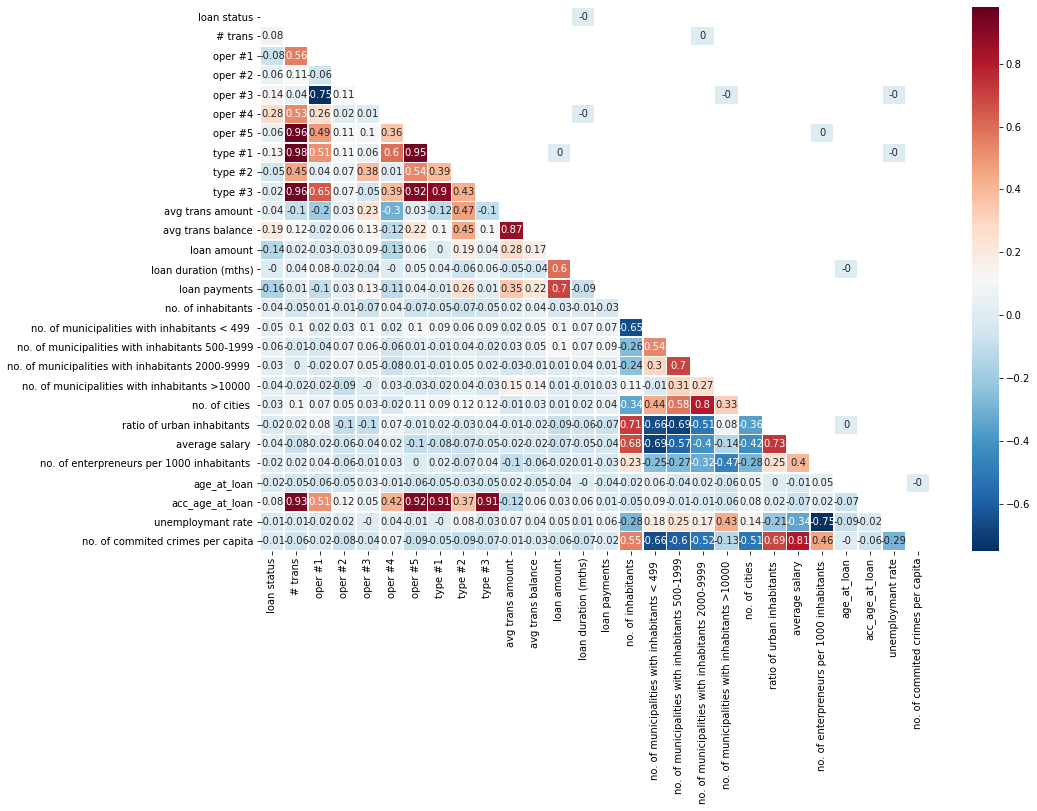

In [113]:
fig, ax = plt.subplots(figsize=(15,10)) 

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(spearmancorr)

sns.heatmap(spearmancorr, 
            xticklabels=spearmancorr.columns,
            yticklabels=spearmancorr.columns,
            cmap='RdBu_r',
            linewidth=0.5,
            annot=True,
            ax=ax,
           mask=matrix)

#### Remarks

## 1.6 Data Visualization: Bivariate/Multivariate Graphs

### N Transactions / Operations / Types 

In [114]:
#sns.pairplot(df_num[['# trans', 'oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3']])

### avg trans amount / avg trans balance

In [115]:
#complete[['avg trans amount', 'avg trans balance']].plot.scatter(x="avg trans amount", y="avg trans balance");

In [116]:
#complete[['avg trans amount', 'avg trans balance']].plot.hexbin(x="avg trans amount", y="avg trans balance", gridsize=25);

### loan amount / avg trans amount / avg trans balance

In [117]:
#fig, ax = plt.subplots()
#complete.plot(kind='scatter',x='avg trans amount', y='avg trans balance', c='loan amount', colormap='RdBu_r', ax=ax)
#plt.show()

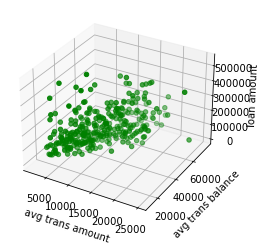

In [118]:
#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(complete['avg trans amount'], complete['avg trans balance'], complete["loan amount"], c='g', marker='o')

ax.set_xlabel('avg trans amount')
ax.set_ylabel('avg trans balance')
ax.set_zlabel('loan amount')


plt.show()

### loan duration (mths) / loan amount

In [119]:
#complete[['loan duration (mths)', 'loan amount']].plot.hexbin(x='loan duration (mths)', y='loan amount', gridsize=25);

### loan payments / avg trans amount, avg trans balance, loan amount

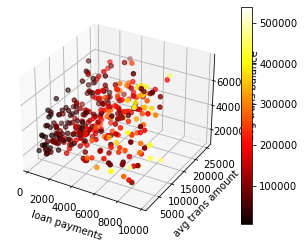

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['loan payments']
y = complete['avg trans amount']
z = complete['avg trans balance']
c = complete['loan amount']

ax.set_xlabel('loan payments')
ax.set_ylabel('avg trans amount')
ax.set_zlabel('avg trans balance')

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

#### Remarks: loan amount increase seem to imply higher loan payments as expected

### loan status / loan amount, loan payments

In [121]:
#fig, ax = plt.subplots()
complete.plot(kind='scatter',x='loan amount', y='loan payments', c='loan status', colormap='winter', ax=ax)
#plt.show()

<Axes3DSubplot:xlabel='loan amount', ylabel='loan payments'>

In [122]:
#complete[['loan amount', 'loan payments', 'loan status']].plot.hexbin(x='loan amount', y='loan payments', C='loan status', gridsize=25);

### no. of cities / no. of inhabitants

In [123]:
#complete[['no. of cities ', 'no. of inhabitants']].plot.scatter(x='no. of cities ', y='no. of inhabitants');

### ratio of urban inhabitants / no. of inhabitants, no. of cities

In [124]:
#fig, ax = plt.subplots()
#complete.plot(kind='scatter',x='no. of cities ', y='no. of inhabitants', c='ratio of urban inhabitants ', colormap='RdBu_r', ax=ax)
#ax.set_ylabel("no. of inhabitants")
#plt.show()

### avg salary / no. of inhabitants, no. of cities, ratio of urban inhabitants

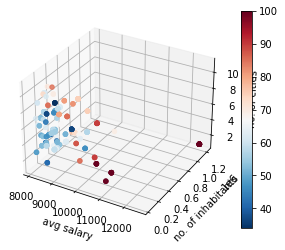

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['average salary ']
y = complete['no. of inhabitants']
z = complete['no. of cities ']
c = complete['ratio of urban inhabitants ']

ax.set_xlabel('avg salary')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('no. of cities')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

### enterpreneurs / no. of inhabitants, ratio of urban inhabitants, avg salary

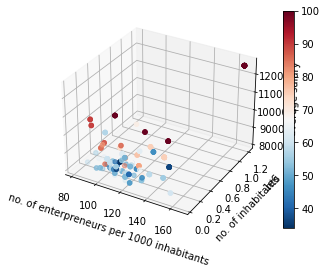

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['no. of enterpreneurs per 1000 inhabitants ']
y = complete['no. of inhabitants']
z = complete['average salary ']
c = complete['ratio of urban inhabitants ']

ax.set_xlabel('no. of enterpreneurs per 1000 inhabitants')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

### unemploymant rate / no. of inhabitants, avg salary, enterpreneurs

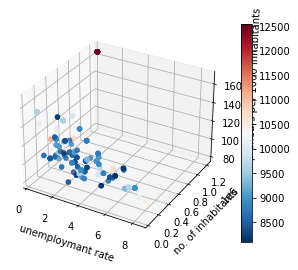

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['unemploymant rate']
y = complete['no. of inhabitants']
z = complete['no. of enterpreneurs per 1000 inhabitants ']
c = complete['average salary ']

ax.set_xlabel('unemploymant rate')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('no. of enterpreneurs per 1000 inhabitants')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

### crimes / no. of cities, no. of inhabitants, ratio of urban inhabitants, avg salary, unemployment

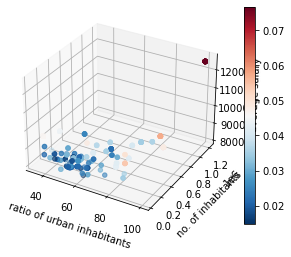

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['no. of inhabitants']
z = complete['average salary ']
c = complete['no. of commited crimes per capita']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

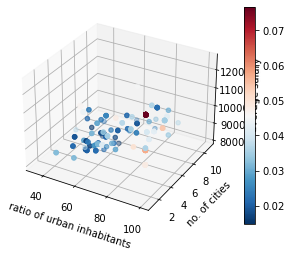

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['no. of cities ']
z = complete['average salary ']
c = complete['no. of commited crimes per capita']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('no. of cities')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

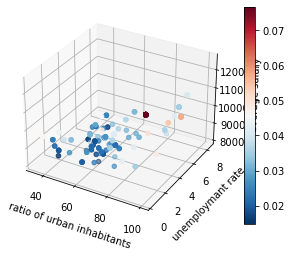

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['unemploymant rate']
z = complete['average salary ']
c = complete['no. of commited crimes per capita']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('unemploymant rate')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

# --- Under here not 'redone' ---

In [131]:
temp = complete[['sex', 'loan status']]

<AxesSubplot:xlabel='loan amount', ylabel='sex'>

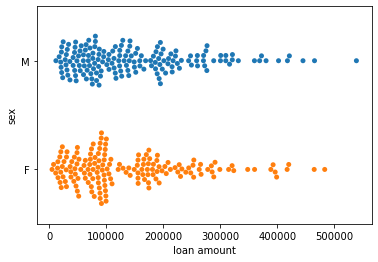

In [132]:
sns.swarmplot(x="loan amount", y="sex", data=complete[['sex', 'loan amount']])

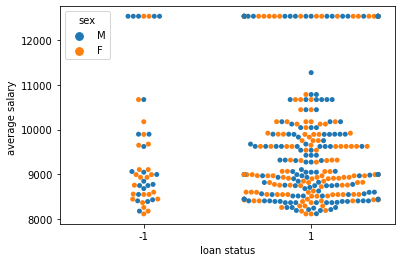

In [133]:
ax = sns.swarmplot(x="loan status", y="average salary ", hue="sex", data=complete[['average salary ', 'loan status', 'sex']])

<IPython.core.display.Javascript object>


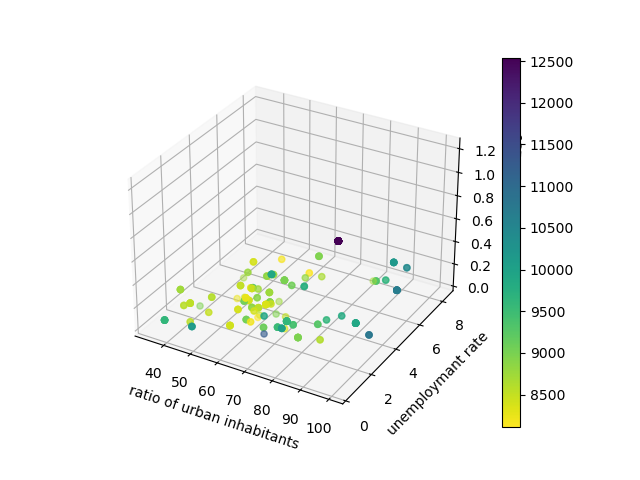

In [134]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['unemploymant rate']
z = complete['no. of inhabitants']
c = complete['average salary ']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('unemploymant rate')
ax.set_zlabel('no. of inhabitants')

img = ax.scatter(x, y, z, c=c, cmap='viridis_r')
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>


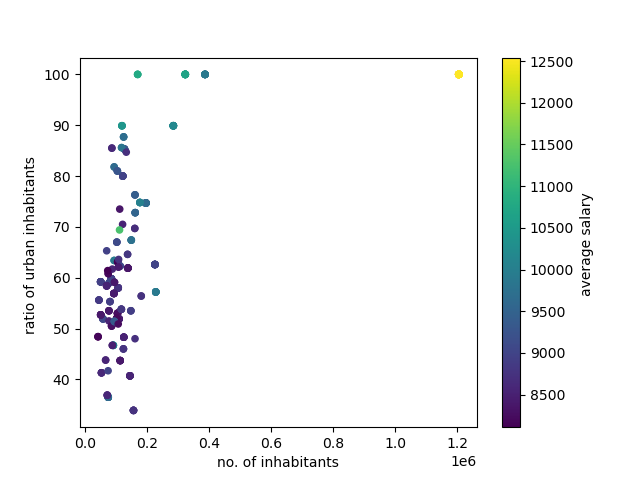

In [135]:

fig, ax = plt.subplots()
complete.plot(kind='scatter',x='no. of inhabitants', y='ratio of urban inhabitants ', c='average salary ', colormap='viridis', ax=ax)
ax.set_xlabel("no. of inhabitants")
plt.show()



<IPython.core.display.Javascript object>


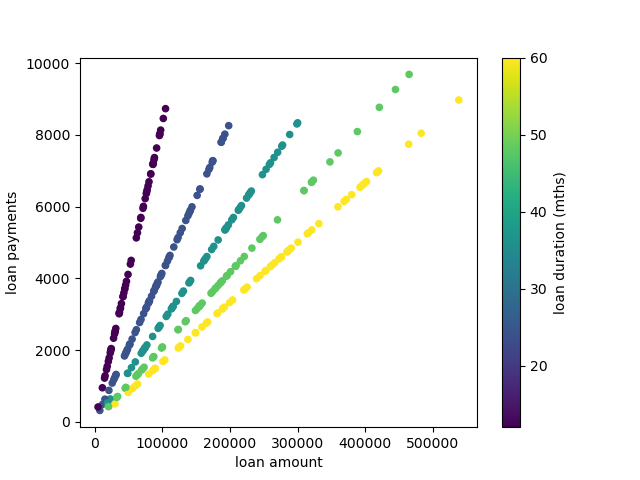

In [136]:
# Number of transactions, loan amount, avg amount per transaction

fig, ax = plt.subplots()
complete.plot(kind='scatter',x='loan amount', y='loan payments', c='loan duration (mths)', colormap='viridis', ax=ax)
ax.set_xlabel("loan amount")
plt.show()

<IPython.core.display.Javascript object>


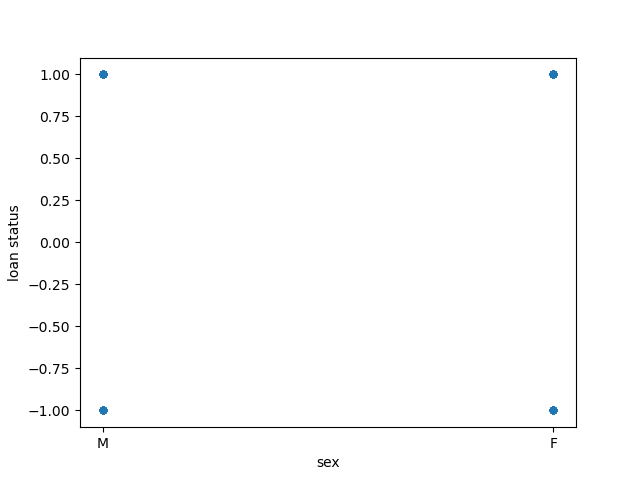

In [137]:
complete['payment_duration'] = complete['loan duration (mths)'] * complete['loan payments']

#fig, ax = plt.subplots()
#complete.plot(kind='scatter',x='payment_duration', y='loan amount')
complete.plot(kind='scatter',x='sex', y='loan status')
#ax.set_xlabel("loan amount")
plt.show()

complete = complete.drop(columns=['payment_duration'])

<IPython.core.display.Javascript object>


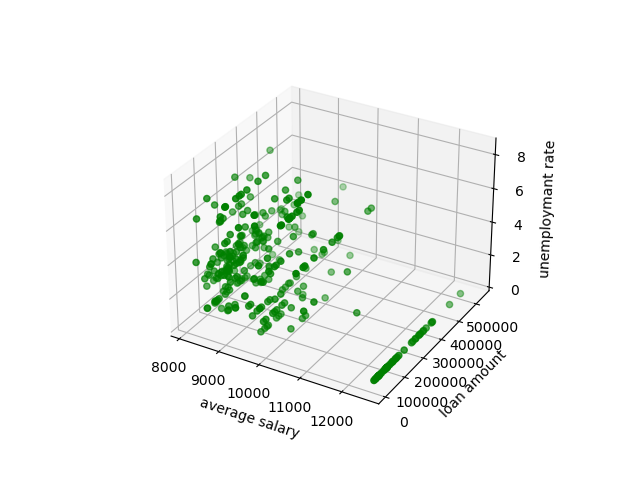

In [138]:
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(complete['average salary '], complete['loan amount'], complete["unemploymant rate"], c='g', marker='o')

ax.set_xlabel('average salary')
ax.set_ylabel('loan amount')
ax.set_zlabel('unemploymant rate')


plt.show()

#### Missing Values

In [139]:
total = complete.isnull().sum().sort_values(ascending=False)
percent = (complete.isnull().sum()/complete.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Total number of rows: ", end=""); print(complete.shape[0])
missing_data.head(10)

Total number of rows: 328


,Total,Percent
no. of commited crimes per capita,0,0.0
oper #5,0,0.0
loan date,0,0.0
avg trans balance,0,0.0
avg trans amount,0,0.0
type #3,0,0.0
type #2,0,0.0
type #1,0,0.0
oper #4,0,0.0
loan duration (mths),0,0.0


In [140]:
#df_num = complete.select_dtypes(include = ['float64', 'int64'])
#df_num.head()

In [141]:
#df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [142]:
corr = complete.corr()['loan status']
corr

loan status                                          1.000000
# trans                                              0.091208
oper #1                                             -0.051181
oper #2                                              0.048169
oper #3                                              0.137795
oper #4                                              0.182415
oper #5                                              0.058313
type #1                                              0.131617
type #2                                             -0.037240
type #3                                              0.019421
avg trans amount                                     0.039858
avg trans balance                                    0.193985
loan amount                                         -0.128237
loan duration (mths)                                -0.003537
loan payments                                       -0.168436
no. of inhabitants                                  -0.009869
no. of m

In [143]:
#sns.heatmap(complete.corr(method='pearson'))

#### Outliers

In [144]:
#subset = complete[['loan amount', 'loan payments']]
#subset['loan payments'] = subset['loan payments'] * 30
#subset.plot.box();

In [145]:
#complete['average salary '].plot.box();

<IPython.core.display.Javascript object>


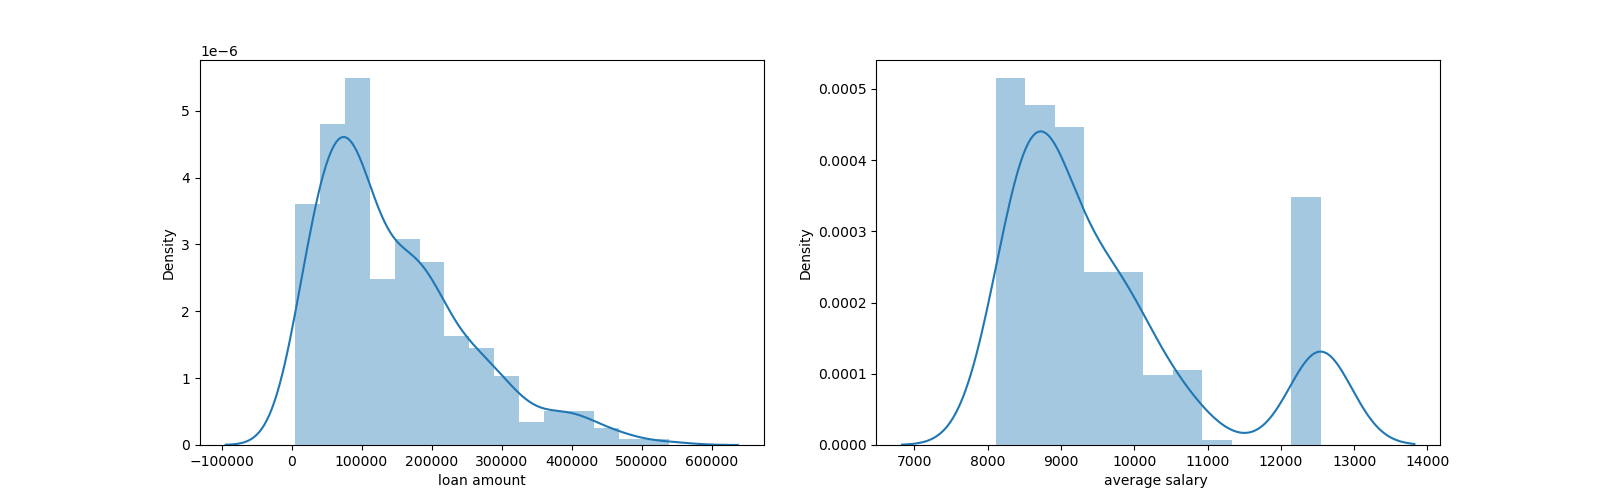

In [146]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(complete['loan amount'])
plt.subplot(1,2,2)
sns.distplot(complete['average salary '])
plt.show()

In [147]:
# Finding how many 
df_mask = complete['average salary '] > 12000
# print(len(complete[df_mask].index))
complete[df_mask]

,loan status,frequency,acc date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan date,loan amount,loan duration (mths),loan payments,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,card type,birthdate,sex,has disponent,age_at_loan,acc_age_at_loan,unemploymant rate,no. of commited crimes per capita
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6888,1,monthly issuance,1993-02-04,115.0,21.0,0.0,0.0,23.0,39.0,62.0,0.0,53.0,8275.28,48944.83,1994-07-11,39576,12,3298,1204953,0,0,0,1,1,100.0,12541,167,None,1980-05-02,F,False,14.190281,1.429158,0.36,0.076677
6647,1,weekly issuance,1993-02-07,85.0,3.0,0.0,15.0,0.0,52.0,46.0,6.0,33.0,9434.44,43944.89,1994-06-01,208320,48,4340,1204953,0,0,0,1,1,100.0,12541,167,None,1968-04-14,F,True,26.130048,1.311431,0.36,0.076677
7240,1,weekly issuance,1993-02-14,27.0,1.0,0.0,6.0,3.0,11.0,14.0,0.0,13.0,18945.97,57188.21,1993-09-06,274740,60,4579,1204953,0,0,0,1,1,100.0,12541,167,None,1978-09-07,M,False,14.997947,0.558522,0.36,0.076677
4959,1,monthly issuance,1993-02-26,54.0,2.0,0.0,10.0,5.0,27.0,29.0,3.0,22.0,7954.26,32590.62,1994-01-05,80952,24,3373,1204953,0,0,0,1,1,100.0,12541,167,None,1945-02-04,M,True,48.917180,0.856947,0.36,0.076677
6499,1,monthly issuance,1993-02-26,54.0,2.0,0.0,10.0,5.0,27.0,29.0,3.0,22.0,7937.75,33312.54,1994-01-05,80952,24,3373,1204953,0,0,0,1,1,100.0,12541,167,None,1945-02-04,M,True,48.917180,0.856947,0.36,0.076677
5479,1,monthly issuance,1993-02-27,73.0,21.0,0.0,0.0,0.0,42.0,33.0,9.0,31.0,16201.56,55582.23,1994-01-10,24516,12,2043,1204953,0,0,0,1,1,100.0,12541,167,None,1958-10-07,M,False,35.260780,0.867899,0.36,0.076677
6960,1,monthly issuance,1993-03-13,153.0,13.0,0.0,22.0,36.0,60.0,89.0,7.0,57.0,6527.34,31375.16,1995-01-11,76416,24,3184,1204953,0,0,0,1,1,100.0,12541,167,None,1937-09-02,M,True,57.357974,1.831622,0.36,0.076677
5724,-1,monthly issuance,1993-03-24,139.0,38.0,0.0,0.0,0.0,79.0,79.0,0.0,60.0,3872.07,18632.93,1995-02-05,316140,60,5269,1204953,0,0,0,1,1,100.0,12541,167,None,1968-02-22,M,False,26.954141,1.869952,0.36,0.076677
6919,1,weekly issuance,1993-03-27,96.0,21.0,0.0,0.0,12.0,48.0,56.0,4.0,36.0,9301.09,40838.76,1994-08-05,120888,36,3358,1204953,0,0,0,1,1,100.0,12541,167,None,1944-04-20,F,False,50.291581,1.357974,0.36,0.076677
